In [7]:
using Random
using Dates
using Optimization
using ComponentArrays
using Lux
using DiffEqFlux: NeuralODE, ADAMW, swish
using DifferentialEquations
using CSV
using DataFrames
using Dates
using Statistics
using Plots
using DataDeps


function download_data(
    data_url="https://raw.githubusercontent.com/SebastianCallh/neural-ode-weather-forecast/master/data/",
    data_local_path="./delhi"
)

    load(file_name) = begin
        data_dep = DataDep("delhi/train", "", "$data_url/$file_name")
        Base.download(data_dep, data_local_path; i_accept_the_terms_of_use=true)
        CSV.read(joinpath(data_local_path, file_name), DataFrame)
    end

    train_df = load("DailyDelhiClimateTrain.csv")
    test_df = load("DailyDelhiClimateTest.csv")
    return vcat(train_df, test_df)
end

df = download_data()

┌ Info: Downloading
│   source = https://raw.githubusercontent.com/SebastianCallh/neural-ode-weather-forecast/master/data//DailyDelhiClimateTrain.csv
│   dest = ./delhi\DailyDelhiClimateTrain.csv
│   progress = 1.0
│   time_taken = 0.03 s
│   time_remaining = 0.0 s
│   average_speed = 3.360 KiB/s
│   downloaded = 117 bytes
│   remaining = 0 bytes
│   total = 117 bytes
└ @ HTTP C:\Users\olarinoyem\.julia\packages\HTTP\z8l0i\src\download.jl:132


┌ Info: Downloading
│   source = https://raw.githubusercontent.com/SebastianCallh/neural-ode-weather-forecast/master/data//DailyDelhiClimateTrain.csv
│   dest = ./delhi\DailyDelhiClimateTrain.csv
│   progress = 1.0
│   time_taken = 0.06 s
│   time_remaining = 0.0 s
│   average_speed = 1.356 MiB/s
│   downloaded = 76.366 KiB
│   remaining = 0 bytes
│   total = 76.366 KiB
└ @ HTTP C:\Users\olarinoyem\.julia\packages\HTTP\z8l0i\src\download.jl:132
┌ Warning: Checksum not provided, add to the Datadep Registration the following hash line
│   hash = 436002a3aef6647ae343e440b67b61d04e380bad3c60284e2cdc660d91514977
└ @ DataDeps C:\Users\olarinoyem\.julia\packages\DataDeps\ae6dT\src\verification.jl:44


┌ Info: Downloading
│   source = https://raw.githubusercontent.com/SebastianCallh/neural-ode-weather-forecast/master/data//DailyDelhiClimateTest.csv
│   dest = ./delhi\DailyDelhiClimateTest.csv
│   progress = 1.0
│   time_taken = 0.0 s
│   time_remaining = 0.0 s
│   average_speed = 113.281 KiB/s
│   downloaded = 116 bytes
│   remaining = 0 bytes
│   total = 116 bytes
└ @ HTTP C:\Users\olarinoyem\.julia\packages\HTTP\z8l0i\src\download.jl:132


┌ Info: Downloading
│   source = https://raw.githubusercontent.com/SebastianCallh/neural-ode-weather-forecast/master/data//DailyDelhiClimateTest.csv
│   dest = ./delhi\DailyDelhiClimateTest.csv
│   progress = 1.0
│   time_taken = 0.0 s
│   time_remaining = 0.0 s
│   average_speed = 6.771 MiB/s
│   downloaded = 6.934 KiB
│   remaining = 0 bytes
│   total = 6.934 KiB
└ @ HTTP C:\Users\olarinoyem\.julia\packages\HTTP\z8l0i\src\download.jl:132
┌ Warning: Checksum not provided, add to the Datadep Registration the following hash line
│   hash = 76ab2829fd7577c98d8b41c296a4fe4552d88d45538e663c856d16bd1b07bdbe
└ @ DataDeps C:\Users\olarinoyem\.julia\packages\DataDeps\ae6dT\src\verification.jl:44


Row,date,meantemp,humidity,wind_speed,meanpressure
,Date,Float64,Float64,Float64,Float64
1,2013-01-01,10.0,84.5,0.0,1015.67
2,2013-01-02,7.4,92.0,2.98,1017.8
3,2013-01-03,7.16667,87.0,4.63333,1018.67
4,2013-01-04,8.66667,71.3333,1.23333,1017.17
5,2013-01-05,6.0,86.8333,3.7,1016.5
6,2013-01-06,7.0,82.8,1.48,1018.0
7,2013-01-07,7.0,78.6,6.3,1020.0
8,2013-01-08,8.85714,63.7143,7.14286,1018.71
9,2013-01-09,14.0,51.25,12.5,1017.0


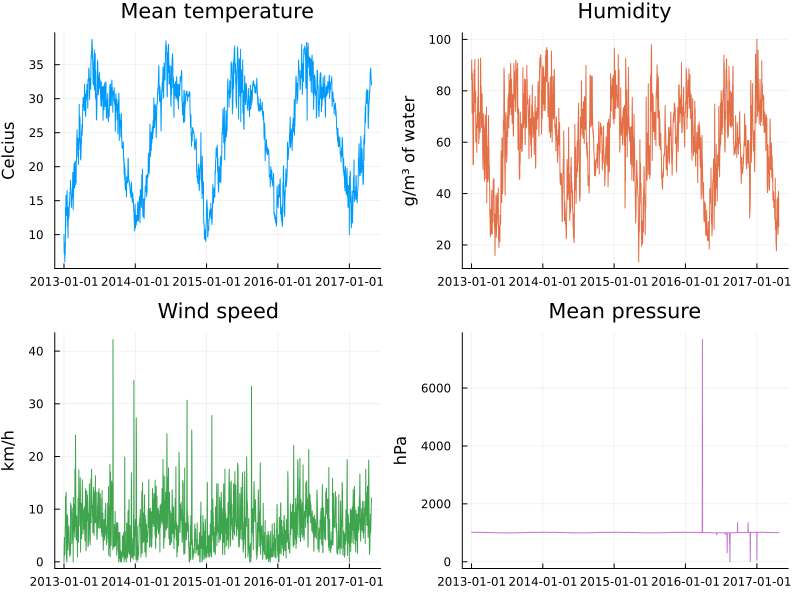

In [8]:
FEATURES = [:meantemp, :humidity, :wind_speed, :meanpressure]
UNITS = ["Celcius", "g/m³ of water", "km/h", "hPa"]
FEATURE_NAMES = ["Mean temperature", "Humidity", "Wind speed", "Mean pressure"]

function plot_data(df)
    plots = map(enumerate(zip(FEATURES, FEATURE_NAMES, UNITS))) do (i, (f, n, u))
        plot(df[:, :date], df[:, f],
            title=n, label=nothing,
            ylabel=u, size=(800, 600),
            color=i)
    end

    n = length(plots)
    plot(plots..., layout=(Int(n / 2), Int(n / 2)))
end

plot_data(df)

size(df) = (52, 7)

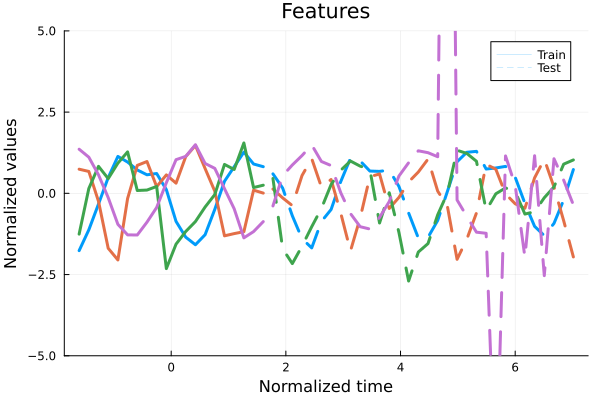

In [9]:
function standardize(x)
    μ = mean(x; dims=2)
    σ = std(x; dims=2)
    z = (x .- μ) ./ σ
    return z, μ, σ
end

function featurize(raw_df, num_train=20)
    raw_df.year = Float64.(year.(raw_df.date))
    raw_df.month = Float64.(month.(raw_df.date))
    df = combine(
        groupby(raw_df, [:year, :month]),
        :date => (d -> mean(year.(d)) .+ mean(month.(d)) ./ 12),
        :meantemp => mean,
        :humidity => mean,
        :wind_speed => mean,
        :meanpressure => mean,
        renamecols=false
    )
    @show size(df)
    t_and_y(df) = df.date', Matrix(select(df, FEATURES))'
    t_train, y_train = t_and_y(df[1:num_train, :])
    t_test, y_test = t_and_y(df[num_train+1:end, :])
    t_train, t_mean, t_scale = standardize(t_train)
    y_train, y_mean, y_scale = standardize(y_train)
    t_test = (t_test .- t_mean) ./ t_scale
    y_test = (y_test .- y_mean) ./ y_scale

    return (
        vec(t_train), y_train,
        vec(t_test), y_test,
        (t_mean, t_scale),
        (y_mean, y_scale)
    )
end

function plot_features(t_train, y_train, t_test, y_test)

    plt_split = plot(
        reshape(t_train, :), y_train',
        linewidth=3, colors=1:4,
        xlabel="Normalized time",
        ylabel="Normalized values",
        label=nothing,
        title="Features"
    )
    plot!(
        plt_split, reshape(t_test, :), y_test',
        linewidth=3, linestyle=:dash,
        color=[1 2 3 4], label=nothing
    )

    plot!(
        plt_split, [0], [0], linewidth=0,
        label="Train", color=1
    )
    plot!(
        plt_split, [0], [0], linewidth=0,
        linestyle=:dash, label="Test",
        color=1,
        ylims=(-5, 5)
    )
end

(
    t_train,
    y_train,
    t_test,
    y_test,
    (t_mean, t_scale),
    (y_mean, y_scale)
) = featurize(df)
plot_features(t_train, y_train, t_test, y_test)

In [13]:
using DiffEqFlux: swish
function neural_ode(t, data_dim)
    f = Lux.Chain(
        Lux.Dense(data_dim, 64, swish),
        Lux.Dense(64, 32, swish),
        Lux.Dense(32, data_dim)
    )

    node = NeuralODE(
        f, extrema(t), Tsit5(),
        saveat=t,
        abstol=1e-9, reltol=1e-9
    )

    rng = Random.default_rng()
    p, state = Lux.setup(rng, f)

    return node, ComponentArray(p), state
end

function train_one_round(node, p, state, y, opt, maxiters, rng, y0=y[:, 1]; kwargs...)
    predict(p) = Array(node(y0, p, state)[1])
    loss(p) = sum(abs2, predict(p) .- y)

    adtype = Optimization.AutoZygote()
    optf = OptimizationFunction((p, _) -> loss(p), adtype)
    optprob = OptimizationProblem(optf, p)
    res = solve(optprob, opt, maxiters=maxiters; kwargs...)
    res.minimizer, state
end

function train(t, y, obs_grid, maxiters, lr, rng, p=nothing, state=nothing; kwargs...)
    log_results(ps, losses) =
        (p, loss) -> begin
            push!(ps, copy(p))
            push!(losses, loss)
            false
        end

    ps, losses = ComponentArray[], Float32[]
    for k in obs_grid
        node, p_new, state_new = neural_ode(t, size(y, 1))
        if p === nothing
            p = p_new
        end
        if state === nothing
            state = state_new
        end

        p, state = train_one_round(
            node, p, state, y, ADAMW(lr), maxiters, rng;
            callback=log_results(ps, losses),
            kwargs...
        )
    end
    ps, state, losses
end

rng = MersenneTwister(123)
obs_grid = 4:4:length(t_train) # we train on an increasing amount of the first k obs
maxiters = 150
lr = 5e-3
ps, state, losses = train(t_train, y_train, obs_grid, maxiters, lr, rng, progress=true);

UndefVarError: UndefVarError: swish not defined